# tutorial

### A. Links to helpful python docs

Recapitation, Simplification, and Mutation: https://pyslim.readthedocs.io/en/latest/tutorial.html#recapitation-simplification-and-mutation

Saving Individuals in .trees file: https://pyslim.readthedocs.io/en/latest/tutorial.html#obtaining-and-saving-individuals

Python tutorial on lists, functions, loops, and more: https://docs.python.org/3/tutorial/

Python API for pyslim: https://pyslim.readthedocs.io/en/latest/python_api.html

### B. Which packages you need + what they do and link to docs

What is pyslim + how to install: https://pypi.org/project/pyslim/

What is tskit: https://tskit.dev/tskit/docs/stable/introduction.html
    + Install tskit: https://tskit.dev/tskit/docs/stable/installation.html

What is NumPy, install, import: https://numpy.org/doc/stable/user/absolute_beginners.html

What is Msprime: https://tskit.dev/msprime/docs/stable/quickstart.html
    + Install Msprime: https://tskit.dev/msprime/docs/stable/installation.html#sec-installation

Install IPython: https://ipython.org/install.html
	(SVG from IPython.display allows us to display trees in SVG format)
    
What is Matplotlib: https://matplotlib.org/stable/index.html
    + Install Matplotlib: https://matplotlib.org/stable/users/installing.html
    (We can use things like matplotlib.pyplot as plt for plotting https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py, matplotlib.cm as cm 
    for color maps, and various widgets)

In [1]:
#We can import these packages into our notebook like this:

import pyslim, tskit
import numpy as np
import msprime
from IPython.display import SVG #for displaying trees in svg format
import matplotlib
import matplotlib.pyplot as plt #plotting
import matplotlib.cm as cm #color maps
#If we want to be able to rotate 3D plots, we can set up the matplotlib widget tool:
%matplotlib widget
#%matplotlib inline

In [2]:
import os #module to run commands on the code line from within python
SLiM = 'slim' #command to run SLiM from your command line

# BASICS

## 0. run a slim sim (Matt)

We first write out our SLiM script as text

In [3]:
SLiM_script = """
initialize() {

   setSeed(1);                                    // set seed for repeatability
   initializeSLiMModelType("nonWF");              // non-Wright-Fisher to allow for local density-dependence and prevent clumping
   initializeSLiMOptions(dimensionality="xy");    // 2 dimensions
   initializeTreeSeq(retainCoalescentOnly=F);     // keep all ancestors that remain in tree sequence
   initializeMutationRate(0.0);                   // we will ignore mutations for now and just deal with the trees
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 999999);       // 1Mb chromosome
   initializeRecombinationRate(1e-8);             // some recombination so we get multiple trees

   // parameter values
   defineConstant("LAMBDA", 4.0); // birth rate
   defineConstant("K", 2.0);      // carrying capacity per unit area
   defineConstant("W", 10);       // width and height of the area
   defineConstant("SIGMA", 0.1);  // interaction and dispersal distance
   
   // spatial interaction for local competition
   initializeInteractionType("i1", "xy", reciprocal=T, maxDistance = 10 * SIGMA);  // interaction for both mate choice and density dependence
   i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);                      // normally distributed around the focal individual with variance SIGMA^2 along both axes
}

reproduction() {
   neighbor_density = i1.totalOfNeighborStrengths(individual);     // strength of competition felt from neighbours
   num_offspring = rpois(1, LAMBDA / (1 + neighbor_density / K));  // number of offspring is Poisson distributed with a mean depending on LAMBDA, neighbor_density, and K
   mate = i1.drawByStrength(individual, 1);                        // single mate drawn randomly weighted by interaction strengths
   if (size(mate) > 0) {                                           // if there is a mate (might not be if no neighbors)
       for (k in seqLen(num_offspring)) {                          // for each offspring
           offspring = p1.addCrossed(individual, mate);            // create by recombination
           pos = individual.spatialPosition + rnorm(2, 0, SIGMA);  // position of offspring is normally distributed around "mother" with variance SIGMA in both axes
           offspring.setSpatialPosition(p1.pointReflected(pos));   // reflecting boundaries
       }
   }
}

1 early() {
   
   
   sim.addSubpop("p1", 2);  //start with just two ancestors (helps make everyone coalesce in a short time)                     

   p1.setSpatialBounds(c(0.0, 0.0, W, W)); // set spatial bounds (square with width W)
   
   // start ancestors in 1x1 square in the center of range
   p1.individuals.x = runif(p1.individualCount) + (W-1)/2; 
   p1.individuals.y = runif(p1.individualCount) + (W-1)/2;
}

early() { 
    p1.fitnessScaling = 1;                   // density dependence occurs in fecundity
    inds = sim.subpopulations.individuals;
    inds[inds.age > 0].fitnessScaling = 0.0; // enforce discrete generations
}

late() {
   i1.evaluate(); //evaluate interaction strengths for next generation
}

late() {
   sim.treeSeqRememberIndividuals(p1.individuals, permanent=F); // retain individuals remaining in the tree sequence
}

1000 late() { 
   sim.treeSeqOutput("spatial_sim.trees"); //save the tree sequence
   catn("Done.");
   sim.simulationFinished();
}

"""

now we run this from the command line (should get a "0" if it worked)

In [4]:
os.system("echo '" + SLiM_script + "' | " + SLiM) #we "echo" the text above and "pipe" it to SLiM

0

## 1. load and simplify tree sequence to a sample (Nadine)

just writing a very brief version here in the meantime, Nadine, so we can work on the sections below, but go ahead and update and annotate this as you like

In [5]:
ts = pyslim.load('spatial_sim.trees') #load tree sequence
np.random.seed(1); n = 5; sampled_nodes = np.random.choice(ts.samples(), 5, replace=False) #take sample of n nodes without replacement (set seed for repeatability)
sts = ts.simplify(sampled_nodes, keep_unary=True) #simplify but keep unary nodes & individuals
# SVG(sts.draw_svg()) #draw if you wish (but kind of ugly with all the unary nodes)
sts #print some summaries of the simplified tree sequence

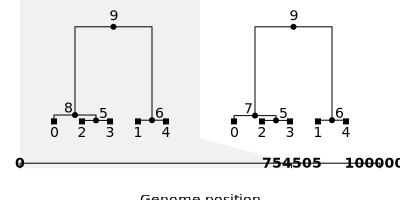

In [6]:
# draw the tree sequence without the unary nodes if you'd like! (there will likely be many fewer trees)
SVG(sts.simplify(keep_unary=False).draw_svg())

## 2. Locate Children and Parents (Pam)

*a few words here*

### Traversing Up a Specific Tree

Often, we want to access a specific tree from the Tree Sequence that pertains to a certain genomic region. This can be done by specifying the index of the tree, or which genomic region it covers. Here, we will extract the relationships between nodes of the first tree (at index 0).

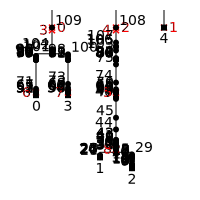

In [30]:
tree0 = sts.at_index(0) #lets look at the very first tree
# print(tree0) #get some more info about this tree
SVG(tree0.draw_svg()) #display the tree

Now we will take each sample node, find its parent, find that parent's parent, and so on. This will help us to plot the parent-child relationships of the tree, and their locations, in 2D and 3D later.

In [31]:
samps = tree0.samples() #retrieve all samples in the tree
root_t = sts.node(tree0.root).time #find how many generations ago the root existed

list_of_nodes = []
list_of_inds = []
    
for i in samps:
    
    nodes = []
    inds = []
    
    samp_node = sts.node(i).id #find the node id of the sample in question
    nodes.append(samp_node) #add it to the list of nodes
    ind = sts.node(i).individual #find the individual this sample node is in
    inds.append(ind) #add it to the list of individuals
    
    parent = tree0.parent(i) #find the parent node of the sample node in question
    nodes.append(parent) #add it to the list of nodes
    p_ind = sts.node(parent).individual #find the individual that parent node is in
    inds.append(p_ind) #add it to the list of individuals
    
    t = sts.node(parent).time #find how many generations ago the parent existed
    
    while t < root_t: #Ensure we find parents of parents until we hit the root
        parent = tree0.parent(parent) #overwrite the parent variable to its parent
        nodes.append(parent) #add it to the list of nodes
        p_ind = sts.node(parent).individual #find the individual that parent node is in
        inds.append(p_ind) #add it to the list of individuals
                 
        t = sts.node(parent).time #overwrite the t variable to the time of the parent's parent
        
    list_of_nodes.append(nodes)
    list_of_inds.append(inds)
        
#print (list_of_nodes) # You can uncomment this to see the list of ancestral nodes for each sample
#print (list_of_inds)

ValueError: More than one root exists. Use tree.roots instead

### Traversing the Entire Tree Sequence

Working on this!

## 3. 2D plotting space trees (Esther)

This section will cover the basics of 2D plotting for a tree sequence. Feel free to check out https://matplotlib.org/stable/gallery/color/named_colors.html for colors,
https://xkcd.com/color/rgb/ for xkcd colors, and 
https://matplotlib.org/2.0.2/api/_as_gen/matplotlib.axes.Axes.plot.html#matplotlib.axes.Axes.plot for some cool data point markers!

### A. Basic 2D plot

Let's use our tree sequence to plot some individuals!

In [9]:
#for t in np.unique(sts.individual_times):
    #print(f"There are {np.sum(sts.individual_times == t)} individuals from time {t}.")

#^This prints the number of individuals per time stamp in the simplified tree sequence (obtained from pyslim vignette:https://pyslim.readthedocs.io/en/latest/vignette_space.html)
#Beware! The printed list is very long.

#pySLiM developers Revision ced27369 (2020). Vignette: A spatial simulation. https://pyslim.readthedocs.io/en/latest/vignette_space.html 

In [10]:
#First, we need to define our plot and the groups that we want to work with:
figure1 = plt.figure()
time = 0 #choose the desired time step (we will use time = 0, or 0 time steps ago)
alive = sts.individuals_alive_at(time) #all individuals alive at time (defined above)
locs = sts.individual_locations[alive] #the locations of individuals from alive 

#Next, set up the x-y coordinates for our chosen individuals:
x=locs[:, 0] #x-axis values of plot using locs
y=locs[:, 1] #y-axis values of plot using locs

#Generate the scatter plot:
plt.scatter(x, y, color= 'cornflowerblue', marker= '*', s=50)
#this function generates a scatter plot, and we can add some customizations:
#customize color with "color = __" or c = "xkcd:____"; e.g. c="xkcd:cornflower blue" or color="cornflowerblue"
#customize shape of points with "marker = <shape of points>" (* = stars!)
#customize size of points with "s = <size of point>"

#Finally, add some labels (plot axes and title):
plt.xlabel('x position') 
plt.ylabel('y position') 
plt.title('Individual locations at time = %d' %time) #Title uses the specific time chosen

plt.show() #display our plot

#Note: feel free to change the value inside <time> to plot other time steps from 0-999.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### B. Some Useful Applications

#### 1. Plot multiple time stamps on one plot (demonstrated using t=0, t=350, & t=999).

Suppose that you would like to compare the locations of individuals from 15 different time stamps on a single plot; could you imagine how tedius it would be to define individuals, their locations, x-y coordinates, and plot customizations 15 different times? To combat this, we can use a for-loop and plot as many data sets as we desire with ease! 

Note: Because we want to customize each data set's markers, colors, etc., we need to use the zip() function in the loop. For more info on zip():https://realpython.com/python-zip-function/

In [11]:
#a quick example of using zip():
times = [0, 350, 999] 
colors = ['cornflowerblue','pink', 'xkcd:seafoam green'] 
assign = zip(times, colors)
list(assign)
#^The output confirms that each element in color is correctly assigned to each element in time. 

[(0, 'cornflowerblue'), (350, 'pink'), (999, 'xkcd:seafoam green')]

In [12]:
figure2 = plt.figure()

times = [0, 350, 999] #create a list of the times we want to plot (we can do as many as we want)
colors = ['cornflowerblue','pink', 'xkcd:seafoam green'] #colors that match the times above
markers = ['*', '^', 's'] #markers that match the times above
#^We can keep doing this to add more customizations (e.g., size of points)

#Now, loop!
for time, color, marker in zip(times, colors, markers): 
    alive = sts.individuals_alive_at(time) #insert "time" and not a single time stamp to iterate through the list of times.
    where = sts.individual_locations[alive] 
    x = where[:,0] 
    y = where[:,1] 
    plt.scatter(x, y, label= 't=%d' %time, color=color, marker=marker, s=50) #input defined indices
    #the label uses whatever times we define in our list.   
    
#Finally, some plotting formalities:
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locations of individuals at multiple different time steps')
plt.legend() #legend for the labels we created above
plt.show()


#Note: Sometimes, individual locations are the same at different time points and they may overlap
    #Try using different sizes of points (s) to see if this is happening!

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 2. Plot Children and Parent locations

The following plots show how we can use the information retrieved from "2. Locate Children and Parents" to plot their locations. We will connect children and parents with lines to show their relations.

Note: Remember that we will be using lists obtained from the first tree within the genome.

In [13]:
#Uncomment to see the lists containing individuals (child + parents):

#print (list_of_inds[0][:]) #prints one list

#lists = [list_of_inds[0][:], list_of_inds[1][:]] #prints two lists
#for i in lists:
    #print (i)

In [14]:
#Plotting a list of child-parents (we will use the first list):

figure3 = plt.figure()
ind_ancestors = list_of_inds[0][:] #Access the first list (index 0) in the list of lists
loc_an = sts.individual_locations[ind_ancestors] #the locations of individuals from ind_ancestors

x = loc_an[:,0] #x, y values
y = loc_an[:,1] 

#Introducing more plotting functions:
plt.plot(x, y, linewidth = 0.3, color = 'black') #add line that connects individuals
plt.xlim(0, 9) #Set axes limits to match the scale of the upcoming graph (for better comparison):
plt.ylim(0, 9)

plt.scatter(x, y, color = 'cornflowerblue', s = 15)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locating children and parents from list #1')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
#Comparing two different lists of individuals:

figure4 = plt.figure()
lists = [list_of_inds[0][:], list_of_inds[4][:]] #put our two desired lists in one list, for which we will loop over.
colors = ['cornflowerblue', 'orange']
labels = ['individuals from list #1', 'individuals from list #5'] #recall that list 1 = index 0
#same as above, but now add a for-loop:
for i, j, k in zip(lists, colors, labels):
    locs = sts.individual_locations[i] 
    x = locs[:,0] 
    y = locs[:,1] 
    plt.plot(x, y, linewidth = 0.3, color = 'black')
    plt.scatter(x, y, label = k, color = j, s = 10)

    
#NOTE: Parents/ancestors may overlap for different lists. We can use another loop to highlight these individuals:

one = list_of_inds[0][:] #First, separate the two lists
two = list_of_inds[4][:]

common = [] #create an empty list where we will append common individuals
for o in one:
    if o in two:
        common.append(o) #if an individual in one exists in two, then append it to the list.

new = sts.individual_locations[common] #use our new list and access locations.
x1 = new[:, 0] 
y1 = new[:, 1]
plt.scatter(x1, y1, label = 'common individuals', color = 'red', s=5) #plot them onto the same plot.

#We can also put this chunk inside the first for-loop to condense things--try it as an exercise! :^)     
          
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locating children and parents from two different lists')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

While 2D plots help us visualize and compare individuals using their locations, we are unable to see where they are with respect to time. Instead of cluttering a 2D plot with all the time stamps, it would be more useful to, say, create a plot for each time and stack them chronologically--we need a 3D plot!

## 4. 3D plotting (Alex)

In [16]:
#Now it's time to plot something! 3d plots are great for looking at changes in patterns over time.
#Let's say we want to see how the positions of individuals in the tree sequence change over time.
#It's easiest and cleanest to set this up by defining a function in Python, then running it for the tree sequence.

def positions(ts):
    #First, we set up the plot using matplotlib.
    fig = plt.figure()
    threed = fig.add_subplot(projection='3d')

    #We need to create lists in which we will hold the x- and y-coordinates of individuals & the time they were born.
    x, y, t = [], [], []
    
    #Now, we iterate over the individuals in the tree sequence and get their positions & birthdates.
    for ind in ts.individuals():
        #The location attribute of the individual class is an array of the coordinates where the individual is located.
        x_pos = ind.location[0]
        y_pos = ind.location[1]
        time = ind.time
        #Now, we append these values to the lists we created.
        x.append(x_pos)
        y.append(y_pos)
        t.append(time)
    #Time to put it on the plot! First, let's set the z-axis to include all of the generational numbers in our simulation.
    #Because tree sequences count generations backwards, we put the axis in reverse so the final gen is on the top.
    threed.set_zlim([1000,0])
    #So that we can see our data, let's set the size of the points to 2.0. The default size is 10.0.
    threed.scatter3D(x, y, t, s=2.0)

#Let's give our function a go with the simplified tree sequence now:
positions(sts)
#With the %matplotlib widget feature at the very beginning of the code, we can rotate our graph
# & see precisely how individuals are positioned in each generation.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# EXTENSIONS

## mutations/selected alleles (Alex)

In [17]:
#One of the tools available from msprime is the "sim_mutations" function, which overlays neutral mutations.
#Let's use this function on our tree sequence.
mts = msprime.sim_mutations(sts, rate=1e-7, random_seed=1) #Seed number added for replicability.
print(mts)

╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │       27║
╟───────────────┼─────────╢
║Sequence Length│1000000.0║
╟───────────────┼─────────╢
║Sample Nodes   │        5║
╟───────────────┼─────────╢
║Total Size     │358.5 KiB║
╚═══════════════╧═════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │2616│ 71.5 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│2517│158.8 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  4 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │ 211│  7.2 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │2575│ 86.2 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Populations│   1│  2.8 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Provenances│   3│  6.4 KiB│          No║
╟───────────┼────┼──

In [18]:
#Now, let's take a look at one of our mutations.
print(mts.mutation(0))

Mutation(id=0, site=0, node=2535, derived_state='T', parent=-1, metadata={'mutation_list': []}, time=960.8744981496129)


## discrete space / metapopulations (Pam)

## slendr (Esther)

slendr is an R package that we can use to generate spatial simulations and analyze the genomic data. Slendr is currently under development, and this tutorial uses the 0.0.0.9000 version.

We can use these spatial models developed by slendr and create a .trees file through SLiM, all under the R environment!

For simplicity, we will use the spatial simulation from "Introduction and basic tutorial", with a few modifications:
- incorporated the sampling() function from the tutorial, "Tree-sequence processing and statistics" to remember individuals at key points.
- extra comments added for clarification.

Please refer to the actual tutorial to understand certain functions and visualize the plots, as the code below is condensed for the purposes of this tutorial. Visit https://bodkan.net/slendr/index.html for more details, installation instructions, and tutorials.

#### slendr script:

In [19]:
slendr = """
library(slendr) #First, open the slendr package in R

#Define our world map and its dimensions:
map <- world(
  xrange = c(-15, 60), # min-max longitude
  yrange = c(20, 65),  # min-max latitude
  crs = "EPSG:3035"    # real projected CRS used internally
)


#define our regions: africa, europe, anatolia
africa <- region(
  "Africa", map,
  polygon = list(c(-18, 20), c(40, 20), c(30, 33),
                 c(20, 32), c(10, 35), c(-8, 35))
)
europe <- region(
  "Europe", map,
  polygon = list(
    c(-8, 35), c(-5, 36), c(10, 38), c(20, 35), c(25, 35),
    c(33, 45), c(20, 58), c(-5, 60), c(-15, 50)
  )
)
anatolia <- region(
  "Anatolia", map,
  polygon = list(c(28, 35), c(40, 35), c(42, 40),
                 c(30, 43), c(27, 40), c(25, 38))
)


#define our six populations (afr, ooa, ehg, eur, ana, yam) as well as their movements:
afr <- population(
  "AFR", parent = "ancestor", time = 52000, N = 3000,
  map = map, polygon = africa
)
ooa <- population(
  "OOA", parent = afr, time = 51000, N = 500, remove = 25000,
  center = c(33, 30), radius = 400e3
)
ooa <- ooa %>% move(
  trajectory = list(c(40, 30), c(50, 30), c(60, 40)),
  start = 50000, end = 40000
)
ehg <- population(
  "EHG", parent = ooa, time = 28000, N = 1000, remove = 6000,
  polygon = list(
    c(26, 55), c(38, 53), c(48, 53), c(60, 53),
    c(60, 60), c(48, 63), c(38, 63), c(26, 60))
)
eur <- population( # European population
  name = "EUR", parent = ehg, time = 25000, N = 2000,
  polygon = europe
)
ana <- population( # Anatolian farmers
  name = "ANA", time = 28000, N = 3000, parent = ooa, remove = 4000,
  center = c(34, 38), radius = 500e3, polygon = anatolia
) %>%
  expand( # expand the range by 2.500 km
    by = 2500e3, start = 10000, end = 7000,
    polygon = join(europe, anatolia)
  )
yam <- population( # Yamnaya steppe population
  name = "YAM", time = 7000, N = 500, parent = ehg, remove = 2500,
  polygon = list(c(26, 50), c(38, 49), c(48, 50),
                 c(48, 56), c(38, 59), c(26, 56))
)
yam <- yam %>%
  move(
    trajectory = c(15, 50),
    start = 5000, end = 3000, snapshots = 8
  )


#simulate geneflow between populations. NOTE: in order for geneflow to occur, population ranges must overlap. If not, an error will occur.
gf <- list(
  geneflow(from = ana, to = yam, rate = 0.5, start = 6500, end = 6400, overlap = FALSE),
  geneflow(from = ana, to = eur, rate = 0.5, start = 8000, end = 6000),
  geneflow(from = yam, to = eur, rate = 0.75, start = 4000, end = 3000)
)

#create our spatial model using compile() in folder "slendr-model"
model <- compile(
  populations = list(afr, ooa, ehg, eur, ana, yam), # populations defined above
  geneflow = gf, # geneflow events defined above
  generation_time = 30,
  resolution = 10e3, # resolution in meters per pixel
  competition_dist = 130e3, mate_dist = 100e3, # spatial interaction in SLiM
  dispersal_dist = 70e3, # how far will offspring end up from their parents
  dir = file.path(tempdir(), "slendr-model"),  overwrite = TRUE
)

#try reading files in our model; you should get an output of the existing files
list.files(file.path(tempdir(), "slendr-model"), pattern = "*.png")

#plot the geneflow graph for our model
plot_graph(model)


#SAMPLING (extra addition)
#We need to sample all populations in order to remember the individuals.
#For simplicity, populations were sampled when they were generated/split or when geneflow occured.
#Used initial population numbers from above and times from plot_graph(model).
afr_sample <- sampling(model, times=c(0,51999), list(afr, 3000))
ooa_samples <- sampling(model, times=c(51000, 40000), list(ooa, 500))
ehg_samples <- sampling(model, times=27000, list(ehg, 1000))
eur_samples <- sampling(model, times=24000, list(eur, 2000))
ana_samples <- sampling(model, times=c(27000,7000), list(ana, 3000))
yam_samples <- sampling(model, times=c(6500, 4000), list(yam, 500))

#Finally, load everything onto SLiM
slim(
  model,
  seq_length = 1, recomb_rate = 0, # simulate only a single locus
  ts_recording = TRUE, #generate a .trees file
  save_locations = TRUE, # save the location of everyone who ever lived
  track_ancestry = 1,
  sampling = rbind(afr_sample, ooa_samples, ehg_samples, eur_samples, ana_samples, yam_samples),
  method = "batch", # change to "gui" to execute the model in SLiMgui
  seed = 314159
)
"""

#Done! After running this in slendr, you should find output_ts.trees in slendr-model
#The original tutorial uses animate(), which shows a gif of the populations moving!

#### IMPORTANT NOTE ON {OUTPUT} FOLDER:

The output folder "slendr-model" contains all of our files (map images, model data, .slim file, .trees file) but may be difficult to find. Try:
1. Change method to "gui" and open in SLiMgui to see the code.
2. Constants and parameters will refer to a folder (e.g., defineConstant("MODEL_DIR", "/var/folders/t2.........tutorial-model"); this is the location of our folder of interest.
3. press COMMAND SHIFT G and type in the entire folder name 
4. If step 3 does not work, type the first few parts (e.g., just /var/folders/) and keep clicking on the folder names that match the subsequent parts of the directory. 
5. You should find "slendr-model"!

### A. Analyze the tree sequence

In [20]:
#let's look at our resulting tree sequence, using the same code from 1. load and simplify tree sequence to a sample
ts = pyslim.load("output_ts.trees")
np.random.seed(314159); n = 5; sampled_nodes = np.random.choice(ts.samples(), 5, replace=False)
sts = ts.simplify(sampled_nodes, keep_unary=True) 
sts

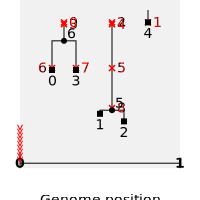

In [21]:
#let's look at our tree!
SVG(sts.simplify(keep_unary=False).draw_svg())

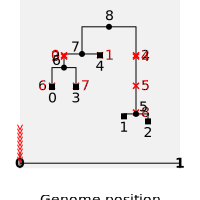

In [22]:
#As you can see, the tree does not coalesce to one common ancestor. We can recapitate it:
rts = sts.recapitate(recombination_rate = 1e-8, Ne=200, random_seed=5)
SVG(rts.simplify(keep_unary=False).draw_svg())

### B. Plotting the spatial genomic data

In [23]:
#We will work with ts and not sts to see the populations and their movement more clearly.
#Like last time, check how many individuals are present in each time stamp:

#for t in np.unique(ts.individual_times):
    #print(f"There are {np.sum(ts.individual_times == t)} individuals from time {t}.")

In [24]:
#Using the same 2D plot code from above

slendr_plot = plt.figure()

times = [900, 1733, 1333, 800, 216] 
colors = ['seagreen','red', 'goldenrod', 'cornflowerblue', 'pink']
#Note: Find the times that match the population sizes we have sampled.
#Colors that match the ones in slendr were chosen for better comparison!

for time, color in zip(times, colors): 
    alive = ts.individuals_alive_at(time)
    where = ts.individual_locations[alive] 
    x = where[:,0] 
    y = where[:,1] 
    plt.scatter(x, y, label= 't=%d' %time, color=color, s=3) 

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('2D plot of slendr spatial simulation')
plt.legend() 
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Note: There is actually no point in the simulation where all populations are present at the same time! We can see this using a 3d plot:

In [25]:
#Using the 3D plot code from above
def positions(ts):
    
    fig = plt.figure()
    threed = fig.add_subplot(projection='3d')

    x, y, t = [], [], []

    for ind in ts.individuals():
        
        x_pos = ind.location[0]
        y_pos = ind.location[1]
        time = ind.time
        
        x.append(x_pos)
        y.append(y_pos)
        t.append(time)
   
    threed.set_zlim([1733,0])
    threed.scatter3D(x, y, t, color='peru', s=1)

positions(ts)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can see in much better detail (try moving the plot around) that the simulation starts with one population and ends with two. Because the six populations were only saved when they appeared/split, there is some data missing in between (in contrast to the animation).

### Connecting children and their parents

Let's use our 3D plot and add lines of descent (connect some children to their parents) for present day samples.

In [26]:
#First, use the 3D plotting code from above:
fig = plt.figure()
threed = fig.add_subplot(projection='3d')

x, y, t = [], [], []

for ind in ts.individuals():

    x_pos = ind.location[0]
    y_pos = ind.location[1]
    time = ind.time

    x.append(x_pos)
    y.append(y_pos)
    t.append(time)

threed.set_zlim([1733,0])
threed.scatter3D(x, y, t, color='peru', s=1)

#Create a list of individuals (random; from present day)
alivelist = [1, 5, 14, 27, 45, 173, 800, 1539, 3450, 4999]

#loop through to make a line of descent for all chosen individuals
for i in alivelist:
    alive_inds = ts.individuals_alive_at(0) #individuals that are alive at the present
    first_node_id = ts.individual(alive_inds[i]).nodes[1] #choose the first node in the list of individuals (random choice)
    #print(ts.node(first_node_id)) #we can also print out some info on this node
    
    first_tree = ts.first() #there is only one tree in this ts, so we'll just look at that
    parray = first_tree.parent_array #parent array (the parent of node i is the ith index of this array)
    
    nodes = [] #lets make a list of nodes that are ancestors of our first node
    node = first_node_id #start with the first node
    
    while node < len(parray) and node > -1: #then, while there exists a parent node
        nodes.append(node) #append it to the list
        node = parray[node] #and then update the current state so that we can find its parent next
    
    locs = []
    times = []
    
    for node in nodes: #now loop through our list of node ids
        ind_id = ts.node(node).individual #get the individual ids for each
        ind = ts.individual(ind_id) #and the individual data
        loc = ind.location #we specifically want the location data
        time = ind.time #and the time the individual was alive
        locs.append(loc) #and append the location to a new list of locations
        times.append(time)
    
    threed.plot(
                [loc[0] for loc in locs], #the x locations
                [loc[0] for loc in locs], #the y locations
                times #the times
               )

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Create a map background for the 2D plot

We will use cartopy to generate a map background to match our 2D plot of the slendr spatial simulation.

For more info + installation: https://scitools.org.uk/cartopy/docs/latest/index.html


Cartopy. v0.11.2. 22-Aug-2014. Met Office. UK. https://github.com/SciTools/cartopy/archive/v0.11.2.tar.gz

In [27]:
#testing map; import cartopy after installation 
import cartopy.crs as ccrs
figmap = plt.figure()
mapping = figmap.add_subplot(projection=ccrs.PlateCarree())
mapping.coastlines()
mapping.set_xlim(-20, 60) #set x, y limits to make the map match the slendr 2D plot
mapping.set_ylim(20, 60)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

times = [900, 1733, 1333, 800, 216] 
colors = ['seagreen','red', 'goldenrod', 'cornflowerblue', 'pink']

x = []
y = []

for time, color in zip(times, colors): 
    alive = ts.individuals_alive_at(time)
    where = ts.individual_locations[alive] 
    x_plot = where[:,0] 
    y_plot = where[:,1] 
    x.append(x_plot)
    y.append(y_plot)
    
figmap = plt.figure()

mapping = figmap.add_subplot(projection=ccrs.PlateCarree())
mapping.coastlines()
#mapping.set_xlim(-20, 60)
#mapping.set_ylim(20, 60)

plt.plot(x,y,transform=ccrs.PlateCarree())
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: setting an array element with a sequence.

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

figmap = plt.figure()

mapping = figmap.add_subplot(projection=ccrs.PlateCarree())
mapping.coastlines()
mapping.set_xlim(-20, 60)
mapping.set_ylim(20, 60)

plt.plot(x,y,transform=ccrs.PlateCarree())

times = [900, 1733, 1333, 800, 216] 
colors = ['seagreen','red', 'goldenrod', 'cornflowerblue', 'pink']

for time, color in zip(times, colors): 
    alive = ts.individuals_alive_at(time)
    where = ts.individual_locations[alive] 
    x = where[:,0] 
    y = where[:,1] 
    plt.scatter(x, y, label= 't=%d' %time, color=color, s=3) 


plt.show()